### Fine-tune the pre-trained FaceNet model towards the Caltech Face Dataset (450 images, 30 peaple) using triplet loss function

In [1]:
import os
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras import backend as K
K.set_image_data_format('channels_first')

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Lambda
from keras.layers import Input, Subtract, add, Dot
from keras import optimizers

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler



C:\Users\xiang.zhai\AppData\Local\Continuum\miniconda3\envs\ML\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from utils.FaceNet_utils import one_hot, distance_based_prediction, evaluate_model, face_dist, load_FaceData, load_base_model

In [3]:
nFace = 450

In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)

    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)

    Returns:
    loss -- real number, value of the loss
    """

#     anchorpositive, anchornegative = y_pred[0], y_pred[1]

#     ### START CODE HERE ### (≈ 4 lines)
#     # Step 1: Compute the (encoding) distance between the anchor and the positive
#     pos_dist = K.sum(K.square(anchorpositive),axis=-1)
#     # Step 2: Compute the (encoding) distance between the anchor and the negative
#     neg_dist = K.sum(K.square(anchornegative),axis=-1)
#     # Step 3: subtract the two previous distances and add alpha.
#     basic_loss = pos_dist - neg_dist + alpha
#     # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
#     loss = K.sum(K.maximum(basic_loss,0.0))
#     ### END CODE HERE ###

    loss = K.sum(K.maximum(y_pred+alpha,0.0))

    return loss

In [5]:
def VecDist(tensors):
    dist = K.sum(K.square(tensors[0]-tensors[1]),axis=-1)
    return dist

In [6]:
def Create_Siamese_model(basemodel,alpha = 0.2):
    basemodel_input_shape = basemodel.layers[0].input.get_shape().as_list()[1:]
    Anchor_Input    = Input(basemodel_input_shape)
    Positive_Input  = Input(basemodel_input_shape)
    Negative_Input  = Input(basemodel_input_shape)
    
    Anchor_Predict   = basemodel(Anchor_Input)
    Positive_Predict = basemodel(Positive_Input)
    Negative_Predict = basemodel(Negative_Input)

    AP_dist = Lambda(VecDist, output_shape=(1,))([Anchor_Predict,Positive_Predict])
    AN_dist = Lambda(VecDist, output_shape=(1,))([Anchor_Predict,Negative_Predict])

    print(AP_dist,AN_dist)
    APN = Subtract()([AP_dist,AN_dist])
    print(APN)
                     
    SiameseModel = Model(inputs = [Anchor_Input, Positive_Input, Negative_Input], outputs = APN)
    
    return SiameseModel 

In [7]:
FNModel = load_base_model()

In [8]:
FNModel.count_params()

3743280

In [9]:
FaceData, labels, labels_OH = load_FaceData()
print(FaceData.shape)
print(labels.shape)
print(labels_OH.shape)

(450, 3, 96, 96)
(450,)
(450, 31)


In [10]:
nPeople = labels_OH.shape[1]

In [13]:
%time FaceEmbedding = FNModel.predict(FaceData)

Wall time: 25.6 s


Text(0.5,1,'feature space')

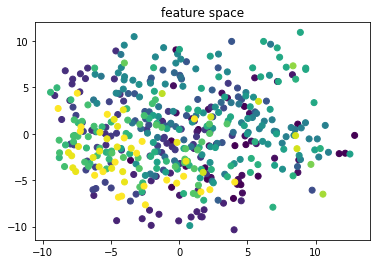

In [14]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels)
plt.title('feature space')

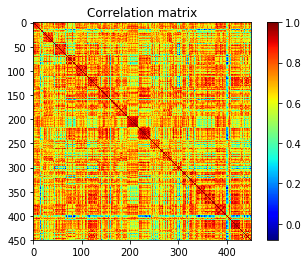

In [15]:
FaceEmbedding_Corr = np.corrcoef(FaceEmbedding)
plt.imshow(FaceEmbedding_Corr,cmap='jet')
plt.title('Correlation matrix')
plt.colorbar()

In [16]:
Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

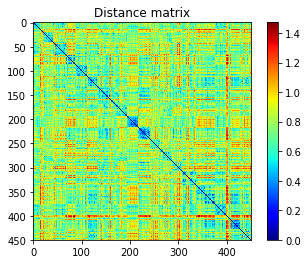

In [17]:
plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

Cross-class distance = 0.805 +\- 0.168
Same-class distance = 0.519 +\- 0.232


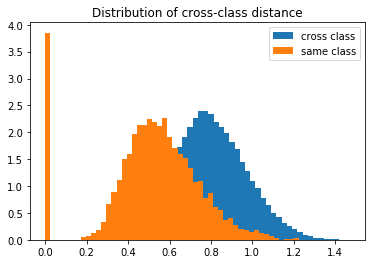

In [25]:
plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

### Note:
Even before doing anything, the direct embedding of faces using FaceNet is already able to recognize faces at decent level.

pct of false positive 23.812 %
pct of false negative 22.103 %
accuracy = 76.268


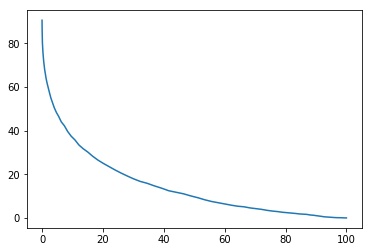

In [26]:
FP = []
FN = []

for threshold in np.arange(0,max(Distances_among_class),0.01):
    FP.append(100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class))
    FN.append(100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class))
    
plt.plot(FP,FN)  
threshold = 0.68
print('pct of false positive %2.3f %%' % (100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)))
print('pct of false negative %2.3f %%' % (100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class)))

print('accuracy = %2.3f' % (100.0*(np.sum(Distances_among_class>threshold)+np.sum(Distances_within_class<threshold))/(len(Distances_among_class)+len(Distances_within_class))))

In [27]:
train_idx = []
test_idx = []
for l in set(labels):
    ind = np.where(labels==l)[0]
    if len(ind)<=1:
        ind_train = list(ind)
        ind_test = []
    else:
        i_split = max([3,int(len(ind)*0.7)])
        ind_train = list(ind[0:i_split])
        ind_test = list(ind[i_split:])
    train_idx += ind_train
    test_idx += ind_test  
print("Training data set has %d face images", len(train_idx))
print("Test data set has %d face images", len(test_idx))

Training data set has %d face images 307
Test data set has %d face images 143


In [32]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 74.126 %


In [33]:
print(nCorrect)

106


## Generate Anchor, positive and negative combinations to train Siamese model built on top of the FaceNet model

In [34]:
SiameseModel = Create_Siamese_model(FNModel)

Tensor("lambda_1/Sum:0", shape=(?,), dtype=float32) Tensor("lambda_2_1/Sum:0", shape=(?,), dtype=float32)
Tensor("subtract_1/sub:0", shape=(?,), dtype=float32)


In [35]:
SiameseModel.output

<tf.Tensor 'subtract_1/sub:0' shape=(?,) dtype=float32>

In [36]:
SiameseModel.compile(optimizer = 'adam', loss = triplet_loss)

In [37]:
SiameseModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
FaceRecoModel (Model)           (None, 128)          3743280     input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [38]:
nFace

450

In [41]:
#find hard to train positive and negative combinations
A = []
P = []
N = []

dist_threshold = 0.4
for i in range(nPeople):
    ifaces = np.where(labels==i)[0]

    iOtherPerson = list(set(range(nFace))-set(ifaces))
    
    for iface in ifaces:
        iSamePerson = list(ifaces)
        
        #find negative faces
        nNegativeFaces = (FaceEmbedding_Dist[iface,iOtherPerson]<dist_threshold).sum()
        nNegativeFaces = max(1,nNegativeFaces)
        if nNegativeFaces == 0:
            continue
        
        iNegativeFaces = FaceEmbedding_Dist[iface,iOtherPerson].argsort()[:nNegativeFaces]
        iNegativeFaces = np.array(iOtherPerson)[iNegativeFaces]
        
        DistNegativeFaces = FaceEmbedding_Dist[iface,list(iNegativeFaces)]
        probNegativeFaces = DistNegativeFaces.max() - DistNegativeFaces + 0.1
        probNegativeFaces = probNegativeFaces/probNegativeFaces.sum()
        
        #find positive faces
        nPositiveFaces = (FaceEmbedding_Dist[iface,iSamePerson]>dist_threshold).sum()
        nPositiveFaces = max(1,nPositiveFaces)
        
        iPositiveFaces = FaceEmbedding_Dist[iface,iSamePerson].argsort()[-nPositiveFaces:]
        iPositiveFaces = np.array(iSamePerson)[iPositiveFaces]
        
        DistPositiveFaces = FaceEmbedding_Dist[iface,list(iPositiveFaces)]
        probPositiveFaces = DistPositiveFaces.max() - DistPositiveFaces + 0.1
        probPositiveFaces = probPositiveFaces/probPositiveFaces.sum()
        
        #samples
        nTotalSample = nNegativeFaces*nPositiveFaces+1
        
        iNegative = np.random.choice(nNegativeFaces,nTotalSample, p = probNegativeFaces)
        iNegative = iNegativeFaces[iNegative]
        iPositive = np.random.choice(nPositiveFaces,nTotalSample, p = probPositiveFaces)
        iPositive = iPositiveFaces[iPositive]

        iAnchor = np.ones((nTotalSample,),dtype=int)*iface
    
        A += list(iAnchor)
        P += list(iPositive)
        N += list(iNegative)

In [42]:
nAPN = len(A)
print('%d number of A, P, N combinations had been identified' % nAPN)

11794 number of A, P, N combinations had been identified


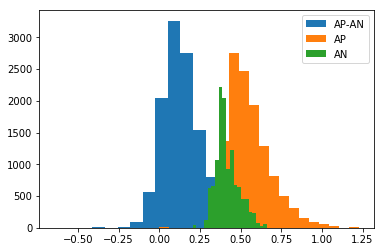

APN = 0.145 +\- 0.128
AP = 0.561 +\- 0.127
AN = 0.416 +\- 0.071


In [43]:
nAPN = len(A)
print('%d number of A, P, N combinations had been identified' % nAPN)
APN, AP, AN = [], [] ,[]
for i, iA in enumerate(A):
    iP, iN = P[i], N[i]
    Dist_AP = FaceEmbedding_Dist[iA,iP]
    Dist_AN = FaceEmbedding_Dist[iA,iN]
    APN.append(Dist_AP-Dist_AN)
    AP.append(Dist_AP)
    AN.append(Dist_AN)

plt.hist(APN,bins=20,label='AP-AN')
plt.hist(AP, bins=20,label='AP')
plt.hist(AN, bins=20,label='AN')
plt.legend()
plt.show()

print('APN = %1.3f +\- %1.3f' % (np.array(APN).mean(), np.array(APN).std()))
print('AP = %1.3f +\- %1.3f' % (np.array(AP).mean(), np.array(AP).std()))
print('AN = %1.3f +\- %1.3f' % (np.array(AN).mean(), np.array(AN).std()))

In [44]:
#SiameseModel.fit([FaceData[A[:5]],FaceData[P[:5]],FaceData[N[:5]]], np.ones((5,)), epochs = 1, batch_size = 32)
SiameseModel.fit([FaceData[A],FaceData[P],FaceData[N]], np.zeros((nAPN,)), epochs = 1, batch_size = 4)

Epoch 1/1
11794/11794 [==============================] - 3846s 326ms/step - loss: 0.0499


In [45]:
%time FaceEmbedding = FNModel.predict(FaceData)

Wall time: 25.5 s


Text(0.5,1,'feature space')

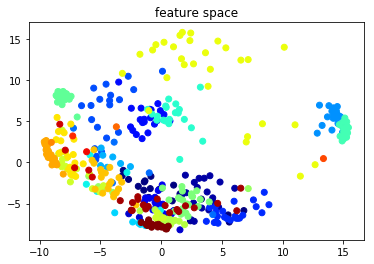

In [57]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels,cmap='jet')
plt.title('feature space')

### Note:
Note that points are more clustered based on color. This means that the model now can seperate different faces better than before

In [58]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 90.909 %


In [59]:
Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

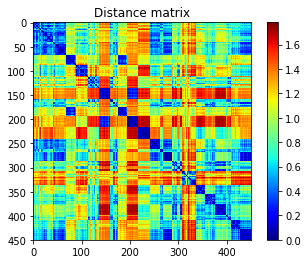

In [60]:
plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

Cross-class distance = 0.993 +\- 0.356
Same-class distance = 0.243 +\- 0.228


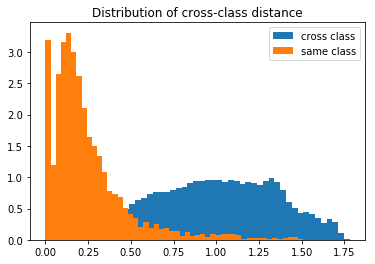

In [61]:
plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

### Note
After only 1 epoch of training on Siamese model, the prediction accuracy based on embedding distance has increased from 74.1% to 91%

In [51]:
FNModel.save('./FaceNetModel/FaceNetModel_epoc1.h5')

In [72]:
#find hard to train positive and negative combinations
A = []
P = []
N = []

dist_threshold_diff = 0.4
dist_threshold_same = 0.3
for i in range(nPeople):
    ifaces = np.where(labels==i)[0]

    iOtherPerson = list(set(range(nFace))-set(ifaces))
    
    for iface in ifaces:
        iSamePerson = list(ifaces)
        
        #find negative faces
        nNegativeFaces = (FaceEmbedding_Dist[iface,iOtherPerson]<dist_threshold_diff).sum()
        nNegativeFaces = max(1,nNegativeFaces)
        if nNegativeFaces == 0:
            continue
        
        iNegativeFaces = FaceEmbedding_Dist[iface,iOtherPerson].argsort()[:nNegativeFaces]
        iNegativeFaces = np.array(iOtherPerson)[iNegativeFaces]
        
        DistNegativeFaces = FaceEmbedding_Dist[iface,list(iNegativeFaces)]
        probNegativeFaces = DistNegativeFaces.max() - DistNegativeFaces + 0.1
        probNegativeFaces = probNegativeFaces/probNegativeFaces.sum()
        
        #find positive faces
        nPositiveFaces = (FaceEmbedding_Dist[iface,iSamePerson]>dist_threshold_same).sum()
        nPositiveFaces = max(1,nPositiveFaces)
        
        iPositiveFaces = FaceEmbedding_Dist[iface,iSamePerson].argsort()[-nPositiveFaces:]
        iPositiveFaces = np.array(iSamePerson)[iPositiveFaces]
        
        DistPositiveFaces = FaceEmbedding_Dist[iface,list(iPositiveFaces)]
        probPositiveFaces = DistPositiveFaces.max() - DistPositiveFaces + 0.1
        probPositiveFaces = probPositiveFaces/probPositiveFaces.sum()
        
        #samples
        nTotalSample = nNegativeFaces*nPositiveFaces+1
        
        iNegative = np.random.choice(nNegativeFaces,nTotalSample, p = probNegativeFaces)
        iNegative = iNegativeFaces[iNegative]
        iPositive = np.random.choice(nPositiveFaces,nTotalSample, p = probPositiveFaces)
        iPositive = iPositiveFaces[iPositive]

        iAnchor = np.ones((nTotalSample,),dtype=int)*iface
    
        A += list(iAnchor)
        P += list(iPositive)
        N += list(iNegative)

11031 number of A, P, N combinations had been identified


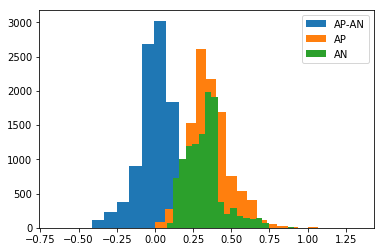

APN = 0.034 +\- 0.145
AP = 0.358 +\- 0.133
AN = 0.324 +\- 0.122


In [73]:
nAPN = len(A)
print('%d number of A, P, N combinations had been identified' % nAPN)
APN, AP, AN = [], [] ,[]
for i, iA in enumerate(A):
    iP, iN = P[i], N[i]
    Dist_AP = FaceEmbedding_Dist[iA,iP]
    Dist_AN = FaceEmbedding_Dist[iA,iN]
    APN.append(Dist_AP-Dist_AN)
    AP.append(Dist_AP)
    AN.append(Dist_AN)

plt.hist(APN,bins=20,label='AP-AN')
plt.hist(AP, bins=20,label='AP')
plt.hist(AN, bins=20,label='AN')
plt.legend()
plt.show()

print('APN = %1.3f +\- %1.3f' % (np.array(APN).mean(), np.array(APN).std()))
print('AP = %1.3f +\- %1.3f' % (np.array(AP).mean(), np.array(AP).std()))
print('AN = %1.3f +\- %1.3f' % (np.array(AN).mean(), np.array(AN).std()))

In [74]:
SiameseModel.fit([FaceData[A],FaceData[P],FaceData[N]], np.zeros((nAPN,)), epochs = 1, batch_size = 16)

Epoch 1/1
11031/11031 [==============================] - 3421s 310ms/step - loss: 0.0438


In [80]:
FaceEmbedding = FNModel.predict(FaceData)

Text(0.5,1,'feature space')

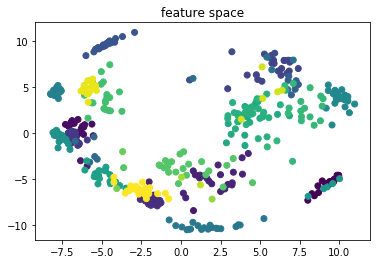

In [81]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels)
plt.title('feature space')

In [82]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 95.804 %


Cross-class distance = 1.327 +\- 0.325
Same-class distance = 0.190 +\- 0.135


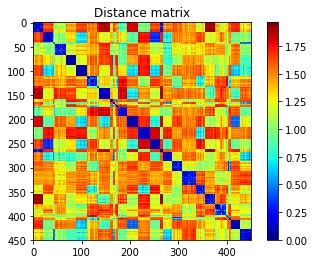

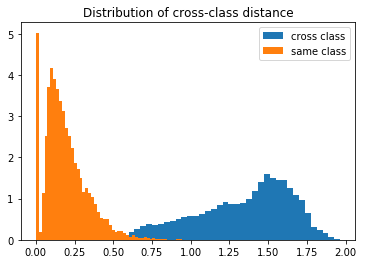

In [83]:
Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

In [79]:
FNModel.save('./FaceNetModel/FaceNetModel_epoc3.h5')